## **ta** module in Python

In [1]:
import pandas as pd
from ta.utils import dropna
from ta.volatility import BollingerBands


# Load datas
df = pd.read_csv('./data/bitcoin_price.csv', sep=',')

# Clean NaN values
df = dropna(df)

# Initialize Bollinger Bands Indicator
indicator_bb = BollingerBands(close=df["Close"], window=20, window_dev=2)  # a BollingerBands class instance is initialized

# Add Bollinger Bands features
df['bb_bbm'] = indicator_bb.bollinger_mavg()
df['bb_bbh'] = indicator_bb.bollinger_hband()
df['bb_bbl'] = indicator_bb.bollinger_lband()

# Add Bollinger Band high indicator
df['bb_bbhi'] = indicator_bb.bollinger_hband_indicator()

# Add Bollinger Band low indicator
df['bb_bbli'] = indicator_bb.bollinger_lband_indicator()

# Add Width Size Bollinger Bands
df['bb_bbw'] = indicator_bb.bollinger_wband()

# Add Percentage Bollinger Bands
df['bb_bbp'] = indicator_bb.bollinger_pband()

# Show dataframe
df

,Date,Open,High,Low,Close,Volume,Market Cap,bb_bbm,bb_bbh,bb_bbl,bb_bbhi,bb_bbli,bb_bbw,bb_bbp
0,"Sep 05, 2017",4228.29,4427.84,3998.11,4376.53,"2,697,970,000","69,954,400,000",NaN,NaN,NaN,0.0,0.0,NaN,NaN
1,"Sep 04, 2017",4591.63,4591.63,4108.40,4236.31,"2,987,330,000","75,955,500,000",NaN,NaN,NaN,0.0,0.0,NaN,NaN
2,"Sep 03, 2017",4585.27,4714.08,4417.59,4582.96,"1,933,190,000","75,841,700,000",NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,"Sep 02, 2017",4901.42,4975.04,4469.24,4578.77,"2,722,140,000","81,060,600,000",NaN,NaN,NaN,0.0,0.0,NaN,NaN
4,"Sep 01, 2017",4701.76,4892.01,4678.53,4892.01,"2,599,080,000","77,748,400,000",NaN,NaN,NaN,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1587,"May 02, 2013",116.38,125.60,92.28,105.21,-,"1,292,190,000",115.2350,127.593745,102.876255,0.0,0.0,21.449638,0.094417
1588,"May 01, 2013",139.00,139.89,107.72,116.99,-,"1,542,820,000",114.9405,126.828244,103.052756,0.0,0.0,20.685040,0.586202
1589,"Apr 30, 2013",144.00,146.93,134.05,139.00,-,"1,597,780,000",115.7905,131.418458,100.162542,1.0,0.0,26.993506,1.242563
1590,"Apr 29, 2013",134.44,147.49,134.00,144.54,-,"1,491,160,000",116.9180,136.837037,96.998963,1.0,0.0,34.073516,1.193357


<AxesSubplot:>

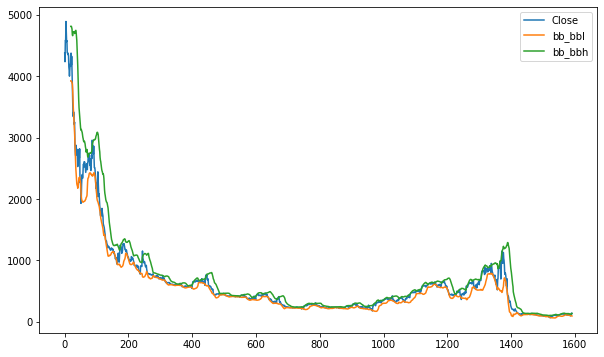

In [2]:
# plot with pandas method
df[["Close", "bb_bbl", "bb_bbh"]].plot(figsize=(10, 6))